In [1]:
import pickle
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

torch.cuda.manual_seed(1)

In [2]:
config = {
    "epoch":1000,
    "batch_size":32,
    "LR":0.0001,
    "hidden_size": 128,
    "num_layers":2
}

In [3]:
class Model(nn.Module):
    def __init__(self,
                 vocab_size=1,
                 embedding_dim=100,
                 hidden_size=1,
                 num_layers=1,
                 dropout=0.5
                ):
        super(Model,self).__init__()
        
        # attribute


        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # net
        

        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        

        self.gru = nn.GRU(
            input_size = embedding_dim,
            hidden_size = self.hidden_size*2,
            num_layers=num_layers,
            dropout = dropout
        )
        
        self.hidden_layer = nn.Linear(
            in_features=self.hidden_size*2,
            out_features=self.hidden_size
        )

        '''
        output layer
        
        
        '''
        self.output_layer = nn.Linear(
            in_features=self.hidden_size,
            out_features=vocab_size
        )
        
    def forward(self,x,hidden):
        
        
        seq_len,batch_size = x.size() # input (seq_len,batch_size)
     
        
        '''
        Embedding layer
        
        in: (seq_len,batch_size)
        out: (seq_len,batch_size,embeding_dim)
        '''
#         print("emb in size: {}\n\n".format(x.size()))
        embedded = self.embedding_layer(x)
#         print("emb out size: {}\n\n".format(embedded.size()))
        
        '''
        GRU layer
        
        in shape: (seq_len, batch, input_size[embedding_size])
        
        out shape: (seq_len, batch, hidden_dim)
        '''

        out,hidden = self.gru(embedded,hidden)
#         print("gru out size: {}\n\n".format(out.size()))
        out = nn.functional.relu(out)
        
        out = out.view(seq_len*batch_size,-1)
        out = self.hidden_layer(out)
        out = nn.functional.relu(out)
        

        
        '''
        output layer
        
        
        in: (seq_len*batch_size,hidden_dim)
        out: (seq_len*batch_size,vocab_size)
        '''
#         output_layer_in = out.view(seq_len*batch_size,-1)
#         print("out layer in  size: {}\n\n".format(output_layer_in.size()))
        out = self.output_layer(out)
#         print("out layer out  size: {}\n\n".format(out.size()))
        
        return out,hidden
    
    def init_hidden(self,batch_size):
        '''
        h_0 of shape (num_layers * num_directions, batch, hidden_size)
        '''
#         return torch.zeros(self.num_layers,batch_size,self.hidden_size)
        return torch.zeros(self.num_layers,batch_size,self.hidden_size*2)
        

In [4]:
with open("./data/id2char_dict.pickle","rb") as f:
    id2char_dict = pickle.load(f)

In [5]:
model = Model(
    vocab_size=len(id2char_dict),
    embedding_dim=300,
    hidden_size=config['hidden_size'],
    num_layers=config['num_layers'],
    
).to(device)

print(model)

Model(
  (embedding_layer): Embedding(3754, 300)
  (gru): GRU(300, 256, num_layers=2, dropout=0.5)
  (hidden_layer): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=3754, bias=True)
)


In [6]:
with open("./data/poetry2id_seqs.pickle","rb") as f:
    poetry2id_seq = pickle.load(f)

In [7]:
x = np.array(poetry2id_seq)
poetry_num, seq_len = x.shape   #(3925, 26)

# new_poetry_num = int(poetry_num/config['batch_size'])

# x = x[:config['batch_size']*new_poetry_num]

x.shape

(3925, 26)

In [8]:
x= torch.from_numpy(np.array(poetry2id_seq))

In [9]:
# [122, 32, 24]

data_loader = Data.DataLoader(
    dataset=x,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2
)

In [10]:
model.train()
l_h = []
epoch_loss = 0

optimizer = torch.optim.Adam(model.parameters(),lr=config["LR"])
criterion = nn.CrossEntropyLoss()



for epoch in range(config['epoch']):
    epoch_loss = 0
    count = 0
    
    for step,d in enumerate(data_loader):
        count+=1
        optimizer.zero_grad()
        d = d.long().transpose(1, 0).contiguous() # torch.Size([24, 32])


        input_,target = d[:-1,:].to(device),d[1:,:].to(device)    # input  第0個 到 倒數第二個 torch.Size([23, 32])
                                            # output 第一個 到 最後 torch.Size([23, 32])
        hidden = model.init_hidden(input_.size(1)).to(device)
        
        
        
        out,hidden = model(input_,hidden)

        loss = criterion(out,target.view(-1))
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()
        l_h.append(loss)
        epoch_loss+=loss.item()
        
        if (step+1) % 50 == 0:
                            
            print('Epoch: ', epoch, '| step ',step+1,'| train loss: %.4f' % loss.item())
    
    print("======== Epoch {} Toal loss {} =========".format(epoch,epoch_loss/count))

Epoch:  0 | step  50 | train loss: 7.9391
Epoch:  0 | step  100 | train loss: 6.6287
======== Epoch 0 Toal loss 7.411202244642304 =========
Epoch:  1 | step  50 | train loss: 6.2981
Epoch:  1 | step  100 | train loss: 6.2227
======== Epoch 1 Toal loss 6.296315259080592 =========
Epoch:  2 | step  50 | train loss: 6.2223
Epoch:  2 | step  100 | train loss: 6.0829
======== Epoch 2 Toal loss 6.194153460060678 =========
Epoch:  3 | step  50 | train loss: 5.9681
Epoch:  3 | step  100 | train loss: 5.7773
======== Epoch 3 Toal loss 5.938915140260526 =========
Epoch:  4 | step  50 | train loss: 5.6342
Epoch:  4 | step  100 | train loss: 5.6361
======== Epoch 4 Toal loss 5.687759108659698 =========
Epoch:  5 | step  50 | train loss: 5.5790
Epoch:  5 | step  100 | train loss: 5.6384
======== Epoch 5 Toal loss 5.610454276325257 =========
Epoch:  6 | step  50 | train loss: 5.4407
Epoch:  6 | step  100 | train loss: 5.5542
======== Epoch 6 Toal loss 5.582114657735437 =========
Epoch:  7 | step  50

Epoch:  58 | step  50 | train loss: 4.7879
Epoch:  58 | step  100 | train loss: 4.7491
======== Epoch 58 Toal loss 4.753566563614016 =========
Epoch:  59 | step  50 | train loss: 4.7452
Epoch:  59 | step  100 | train loss: 4.7664
======== Epoch 59 Toal loss 4.740584505282767 =========
Epoch:  60 | step  50 | train loss: 4.6422
Epoch:  60 | step  100 | train loss: 4.7103
======== Epoch 60 Toal loss 4.730240407028819 =========
Epoch:  61 | step  50 | train loss: 4.9007
Epoch:  61 | step  100 | train loss: 4.6777
======== Epoch 61 Toal loss 4.718006955898874 =========
Epoch:  62 | step  50 | train loss: 4.7318
Epoch:  62 | step  100 | train loss: 4.7467
======== Epoch 62 Toal loss 4.709270620733742 =========
Epoch:  63 | step  50 | train loss: 4.6202
Epoch:  63 | step  100 | train loss: 4.6719
======== Epoch 63 Toal loss 4.696569322570553 =========
Epoch:  64 | step  50 | train loss: 4.6389
Epoch:  64 | step  100 | train loss: 4.7294
======== Epoch 64 Toal loss 4.686535629799695 =========

Epoch:  115 | step  50 | train loss: 4.2701
Epoch:  115 | step  100 | train loss: 4.3604
======== Epoch 115 Toal loss 4.25371475917537 =========
Epoch:  116 | step  50 | train loss: 4.1797
Epoch:  116 | step  100 | train loss: 4.2364
======== Epoch 116 Toal loss 4.246181999764791 =========
Epoch:  117 | step  50 | train loss: 4.3415
Epoch:  117 | step  100 | train loss: 4.2300
======== Epoch 117 Toal loss 4.238810682684425 =========
Epoch:  118 | step  50 | train loss: 4.1280
Epoch:  118 | step  100 | train loss: 4.2008
======== Epoch 118 Toal loss 4.232003529866536 =========
Epoch:  119 | step  50 | train loss: 4.1675
Epoch:  119 | step  100 | train loss: 4.1756
======== Epoch 119 Toal loss 4.222343762715657 =========
Epoch:  120 | step  50 | train loss: 4.2965
Epoch:  120 | step  100 | train loss: 4.1038
======== Epoch 120 Toal loss 4.215833260761044 =========
Epoch:  121 | step  50 | train loss: 4.1402
Epoch:  121 | step  100 | train loss: 4.1942
======== Epoch 121 Toal loss 4.20736

Epoch:  171 | step  100 | train loss: 3.8290
======== Epoch 171 Toal loss 3.878551045084387 =========
Epoch:  172 | step  50 | train loss: 3.8806
Epoch:  172 | step  100 | train loss: 3.9203
======== Epoch 172 Toal loss 3.871245393908121 =========
Epoch:  173 | step  50 | train loss: 3.8698
Epoch:  173 | step  100 | train loss: 3.8540
======== Epoch 173 Toal loss 3.863753714212557 =========
Epoch:  174 | step  50 | train loss: 3.8109
Epoch:  174 | step  100 | train loss: 3.9469
======== Epoch 174 Toal loss 3.854089281423305 =========
Epoch:  175 | step  50 | train loss: 3.7254
Epoch:  175 | step  100 | train loss: 3.9772
======== Epoch 175 Toal loss 3.850003849200117 =========
Epoch:  176 | step  50 | train loss: 3.7451
Epoch:  176 | step  100 | train loss: 3.9763
======== Epoch 176 Toal loss 3.842551062746746 =========
Epoch:  177 | step  50 | train loss: 3.7132
Epoch:  177 | step  100 | train loss: 3.9437
======== Epoch 177 Toal loss 3.8358239991878107 =========
Epoch:  178 | step  5

Epoch:  227 | step  100 | train loss: 3.5530
======== Epoch 227 Toal loss 3.542559236045775 =========
Epoch:  228 | step  50 | train loss: 3.5171
Epoch:  228 | step  100 | train loss: 3.4592
======== Epoch 228 Toal loss 3.537996673971657 =========
Epoch:  229 | step  50 | train loss: 3.5927
Epoch:  229 | step  100 | train loss: 3.5818
======== Epoch 229 Toal loss 3.532080636761053 =========
Epoch:  230 | step  50 | train loss: 3.4928
Epoch:  230 | step  100 | train loss: 3.6520
======== Epoch 230 Toal loss 3.528750489397747 =========
Epoch:  231 | step  50 | train loss: 3.4024
Epoch:  231 | step  100 | train loss: 3.5513
======== Epoch 231 Toal loss 3.5208140679491247 =========
Epoch:  232 | step  50 | train loss: 3.5713
Epoch:  232 | step  100 | train loss: 3.4457
======== Epoch 232 Toal loss 3.5170798921972755 =========
Epoch:  233 | step  50 | train loss: 3.3891
Epoch:  233 | step  100 | train loss: 3.4612
======== Epoch 233 Toal loss 3.5126015035117546 =========
Epoch:  234 | step 

Epoch:  283 | step  100 | train loss: 3.3963
======== Epoch 283 Toal loss 3.2477489293106205 =========
Epoch:  284 | step  50 | train loss: 3.2619
Epoch:  284 | step  100 | train loss: 3.2042
======== Epoch 284 Toal loss 3.24456922600909 =========
Epoch:  285 | step  50 | train loss: 3.2034
Epoch:  285 | step  100 | train loss: 3.2922
======== Epoch 285 Toal loss 3.2374287756477913 =========
Epoch:  286 | step  50 | train loss: 3.1986
Epoch:  286 | step  100 | train loss: 3.3400
======== Epoch 286 Toal loss 3.2350135101535455 =========
Epoch:  287 | step  50 | train loss: 3.1810
Epoch:  287 | step  100 | train loss: 3.3092
======== Epoch 287 Toal loss 3.229684223004473 =========
Epoch:  288 | step  50 | train loss: 3.3982
Epoch:  288 | step  100 | train loss: 3.3215
======== Epoch 288 Toal loss 3.221318361235828 =========
Epoch:  289 | step  50 | train loss: 3.2280
Epoch:  289 | step  100 | train loss: 3.4899
======== Epoch 289 Toal loss 3.2205754314980855 =========
Epoch:  290 | step 

Epoch:  339 | step  100 | train loss: 2.8676
======== Epoch 339 Toal loss 2.9849842544493637 =========
Epoch:  340 | step  50 | train loss: 2.9730
Epoch:  340 | step  100 | train loss: 3.1834
======== Epoch 340 Toal loss 2.980473051226236 =========
Epoch:  341 | step  50 | train loss: 3.0619
Epoch:  341 | step  100 | train loss: 2.9608
======== Epoch 341 Toal loss 2.9775431737667177 =========
Epoch:  342 | step  50 | train loss: 2.9445
Epoch:  342 | step  100 | train loss: 3.0687
======== Epoch 342 Toal loss 2.9722379998462958 =========
Epoch:  343 | step  50 | train loss: 2.9842
Epoch:  343 | step  100 | train loss: 3.0179
======== Epoch 343 Toal loss 2.9688986588299757 =========
Epoch:  344 | step  50 | train loss: 2.9950
Epoch:  344 | step  100 | train loss: 2.8700
======== Epoch 344 Toal loss 2.964227934193805 =========
Epoch:  345 | step  50 | train loss: 3.0564
Epoch:  345 | step  100 | train loss: 2.7302
======== Epoch 345 Toal loss 2.9581771711023843 =========
Epoch:  346 | ste

Epoch:  395 | step  100 | train loss: 2.7963
======== Epoch 395 Toal loss 2.750917392048409 =========
Epoch:  396 | step  50 | train loss: 2.7090
Epoch:  396 | step  100 | train loss: 2.7565
======== Epoch 396 Toal loss 2.7392953062445167 =========
Epoch:  397 | step  50 | train loss: 2.7207
Epoch:  397 | step  100 | train loss: 2.8944
======== Epoch 397 Toal loss 2.7426111388012644 =========
Epoch:  398 | step  50 | train loss: 2.7915
Epoch:  398 | step  100 | train loss: 2.6213
======== Epoch 398 Toal loss 2.7342126253174572 =========
Epoch:  399 | step  50 | train loss: 2.6088
Epoch:  399 | step  100 | train loss: 2.8482
======== Epoch 399 Toal loss 2.730392717733616 =========
Epoch:  400 | step  50 | train loss: 2.6828
Epoch:  400 | step  100 | train loss: 2.6199
======== Epoch 400 Toal loss 2.7286360399509832 =========
Epoch:  401 | step  50 | train loss: 2.7299
Epoch:  401 | step  100 | train loss: 2.7560
======== Epoch 401 Toal loss 2.726004418318834 =========
Epoch:  402 | step

Epoch:  451 | step  100 | train loss: 2.5197
======== Epoch 451 Toal loss 2.5289417883244956 =========
Epoch:  452 | step  50 | train loss: 2.5739
Epoch:  452 | step  100 | train loss: 2.6529
======== Epoch 452 Toal loss 2.5300885274158262 =========
Epoch:  453 | step  50 | train loss: 2.5467
Epoch:  453 | step  100 | train loss: 2.5788
======== Epoch 453 Toal loss 2.5245090538893287 =========
Epoch:  454 | step  50 | train loss: 2.6202
Epoch:  454 | step  100 | train loss: 2.5169
======== Epoch 454 Toal loss 2.5256551920883052 =========
Epoch:  455 | step  50 | train loss: 2.5319
Epoch:  455 | step  100 | train loss: 2.4405
======== Epoch 455 Toal loss 2.521222323906131 =========
Epoch:  456 | step  50 | train loss: 2.4204
Epoch:  456 | step  100 | train loss: 2.5186
======== Epoch 456 Toal loss 2.515246747955074 =========
Epoch:  457 | step  50 | train loss: 2.4146
Epoch:  457 | step  100 | train loss: 2.4831
======== Epoch 457 Toal loss 2.5118063504133765 =========
Epoch:  458 | ste

Epoch:  507 | step  100 | train loss: 2.4156
======== Epoch 507 Toal loss 2.337840566790201 =========
Epoch:  508 | step  50 | train loss: 2.3811
Epoch:  508 | step  100 | train loss: 2.3574
======== Epoch 508 Toal loss 2.337728981080094 =========
Epoch:  509 | step  50 | train loss: 2.3017
Epoch:  509 | step  100 | train loss: 2.3491
======== Epoch 509 Toal loss 2.335998426607954 =========
Epoch:  510 | step  50 | train loss: 2.5378
Epoch:  510 | step  100 | train loss: 2.2896
======== Epoch 510 Toal loss 2.3351797340362053 =========
Epoch:  511 | step  50 | train loss: 2.3694
Epoch:  511 | step  100 | train loss: 2.4839
======== Epoch 511 Toal loss 2.324184487505657 =========
Epoch:  512 | step  50 | train loss: 2.3815
Epoch:  512 | step  100 | train loss: 2.2227
======== Epoch 512 Toal loss 2.3253959252582335 =========
Epoch:  513 | step  50 | train loss: 2.3094
Epoch:  513 | step  100 | train loss: 2.5009
======== Epoch 513 Toal loss 2.316755765821876 =========
Epoch:  514 | step  

Epoch:  563 | step  100 | train loss: 2.1751
======== Epoch 563 Toal loss 2.166734771030705 =========
Epoch:  564 | step  50 | train loss: 2.1410
Epoch:  564 | step  100 | train loss: 2.0253
======== Epoch 564 Toal loss 2.1695601048508313 =========
Epoch:  565 | step  50 | train loss: 2.1334
Epoch:  565 | step  100 | train loss: 2.2091
======== Epoch 565 Toal loss 2.161707721105436 =========
Epoch:  566 | step  50 | train loss: 2.1237
Epoch:  566 | step  100 | train loss: 2.1501
======== Epoch 566 Toal loss 2.1568125496065713 =========
Epoch:  567 | step  50 | train loss: 2.1494
Epoch:  567 | step  100 | train loss: 2.0308
======== Epoch 567 Toal loss 2.1597351291315343 =========
Epoch:  568 | step  50 | train loss: 2.2396
Epoch:  568 | step  100 | train loss: 2.1551
======== Epoch 568 Toal loss 2.151872106683933 =========
Epoch:  569 | step  50 | train loss: 2.0391
Epoch:  569 | step  100 | train loss: 2.2304
======== Epoch 569 Toal loss 2.1546009023015094 =========
Epoch:  570 | step

Epoch:  619 | step  100 | train loss: 1.9828
======== Epoch 619 Toal loss 2.0095598707354165 =========
Epoch:  620 | step  50 | train loss: 1.9538
Epoch:  620 | step  100 | train loss: 2.0548
======== Epoch 620 Toal loss 2.0100578399208504 =========
Epoch:  621 | step  50 | train loss: 2.0394
Epoch:  621 | step  100 | train loss: 2.1728
======== Epoch 621 Toal loss 2.006632811654874 =========
Epoch:  622 | step  50 | train loss: 1.9623
Epoch:  622 | step  100 | train loss: 2.1287
======== Epoch 622 Toal loss 2.0055327250705504 =========
Epoch:  623 | step  50 | train loss: 1.9699
Epoch:  623 | step  100 | train loss: 1.9490
======== Epoch 623 Toal loss 2.006241223676418 =========
Epoch:  624 | step  50 | train loss: 2.0260
Epoch:  624 | step  100 | train loss: 2.1050
======== Epoch 624 Toal loss 2.000233499984431 =========
Epoch:  625 | step  50 | train loss: 1.9828
Epoch:  625 | step  100 | train loss: 2.1080
======== Epoch 625 Toal loss 2.0003613892609513 =========
Epoch:  626 | step

Epoch:  675 | step  100 | train loss: 1.9379
======== Epoch 675 Toal loss 1.868881484357322 =========
Epoch:  676 | step  50 | train loss: 1.9159
Epoch:  676 | step  100 | train loss: 1.9934
======== Epoch 676 Toal loss 1.8708878212827977 =========
Epoch:  677 | step  50 | train loss: 1.8729
Epoch:  677 | step  100 | train loss: 1.9019
======== Epoch 677 Toal loss 1.8645138226873506 =========
Epoch:  678 | step  50 | train loss: 1.7695
Epoch:  678 | step  100 | train loss: 1.7516
======== Epoch 678 Toal loss 1.8645237403187325 =========
Epoch:  679 | step  50 | train loss: 1.8802
Epoch:  679 | step  100 | train loss: 1.8010
======== Epoch 679 Toal loss 1.8622290758582634 =========
Epoch:  680 | step  50 | train loss: 1.9301
Epoch:  680 | step  100 | train loss: 1.8575
======== Epoch 680 Toal loss 1.8554004556764432 =========
Epoch:  681 | step  50 | train loss: 1.9286
Epoch:  681 | step  100 | train loss: 1.8461
======== Epoch 681 Toal loss 1.8547080571089334 =========
Epoch:  682 | st

Epoch:  731 | step  100 | train loss: 1.6485
======== Epoch 731 Toal loss 1.7398996420992099 =========
Epoch:  732 | step  50 | train loss: 1.7059
Epoch:  732 | step  100 | train loss: 1.7542
======== Epoch 732 Toal loss 1.7409777418384706 =========
Epoch:  733 | step  50 | train loss: 1.8021
Epoch:  733 | step  100 | train loss: 1.8328
======== Epoch 733 Toal loss 1.7379850750047017 =========
Epoch:  734 | step  50 | train loss: 1.6669
Epoch:  734 | step  100 | train loss: 1.6992
======== Epoch 734 Toal loss 1.7331153144681357 =========
Epoch:  735 | step  50 | train loss: 1.8339
Epoch:  735 | step  100 | train loss: 1.7344
======== Epoch 735 Toal loss 1.7307930574184511 =========
Epoch:  736 | step  50 | train loss: 1.5683
Epoch:  736 | step  100 | train loss: 1.6287
======== Epoch 736 Toal loss 1.7285748254962083 =========
Epoch:  737 | step  50 | train loss: 1.7351
Epoch:  737 | step  100 | train loss: 1.6834
======== Epoch 737 Toal loss 1.7254545339723912 =========
Epoch:  738 | s

Epoch:  787 | step  100 | train loss: 1.7317
======== Epoch 787 Toal loss 1.6213777171887034 =========
Epoch:  788 | step  50 | train loss: 1.6503
Epoch:  788 | step  100 | train loss: 1.5329
======== Epoch 788 Toal loss 1.617895375422346 =========
Epoch:  789 | step  50 | train loss: 1.5888
Epoch:  789 | step  100 | train loss: 1.6768
======== Epoch 789 Toal loss 1.6162961653577603 =========
Epoch:  790 | step  50 | train loss: 1.6010
Epoch:  790 | step  100 | train loss: 1.6233
======== Epoch 790 Toal loss 1.6169116913787718 =========
Epoch:  791 | step  50 | train loss: 1.6361
Epoch:  791 | step  100 | train loss: 1.5624
======== Epoch 791 Toal loss 1.6164991254728984 =========
Epoch:  792 | step  50 | train loss: 1.6481
Epoch:  792 | step  100 | train loss: 1.5956
======== Epoch 792 Toal loss 1.6160169461878335 =========
Epoch:  793 | step  50 | train loss: 1.4975
Epoch:  793 | step  100 | train loss: 1.6813
======== Epoch 793 Toal loss 1.613447644846226 =========
Epoch:  794 | ste

Epoch:  843 | step  100 | train loss: 1.5598
======== Epoch 843 Toal loss 1.5181932274888201 =========
Epoch:  844 | step  50 | train loss: 1.5132
Epoch:  844 | step  100 | train loss: 1.6240
======== Epoch 844 Toal loss 1.5174089931860202 =========
Epoch:  845 | step  50 | train loss: 1.4004
Epoch:  845 | step  100 | train loss: 1.5460
======== Epoch 845 Toal loss 1.5129059708215358 =========
Epoch:  846 | step  50 | train loss: 1.3997
Epoch:  846 | step  100 | train loss: 1.6251
======== Epoch 846 Toal loss 1.5116202404828576 =========
Epoch:  847 | step  50 | train loss: 1.4741
Epoch:  847 | step  100 | train loss: 1.5660
======== Epoch 847 Toal loss 1.5138672212275064 =========
Epoch:  848 | step  50 | train loss: 1.5191
Epoch:  848 | step  100 | train loss: 1.5052
======== Epoch 848 Toal loss 1.512097940212343 =========
Epoch:  849 | step  50 | train loss: 1.5557
Epoch:  849 | step  100 | train loss: 1.6047
======== Epoch 849 Toal loss 1.5110970764625362 =========
Epoch:  850 | st

Epoch:  899 | step  100 | train loss: 1.2629
======== Epoch 899 Toal loss 1.427278577796812 =========
Epoch:  900 | step  50 | train loss: 1.3545
Epoch:  900 | step  100 | train loss: 1.3473
======== Epoch 900 Toal loss 1.422812550048518 =========
Epoch:  901 | step  50 | train loss: 1.3601
Epoch:  901 | step  100 | train loss: 1.3327
======== Epoch 901 Toal loss 1.4203404730897609 =========
Epoch:  902 | step  50 | train loss: 1.2261
Epoch:  902 | step  100 | train loss: 1.5760
======== Epoch 902 Toal loss 1.4198409289848515 =========
Epoch:  903 | step  50 | train loss: 1.4759
Epoch:  903 | step  100 | train loss: 1.4469
======== Epoch 903 Toal loss 1.4195898296387215 =========
Epoch:  904 | step  50 | train loss: 1.4155
Epoch:  904 | step  100 | train loss: 1.4343
======== Epoch 904 Toal loss 1.4169295338111194 =========
Epoch:  905 | step  50 | train loss: 1.4319
Epoch:  905 | step  100 | train loss: 1.3960
======== Epoch 905 Toal loss 1.4171117466639698 =========
Epoch:  906 | ste

Epoch:  955 | step  100 | train loss: 1.3995
======== Epoch 955 Toal loss 1.3390438837733696 =========
Epoch:  956 | step  50 | train loss: 1.2805
Epoch:  956 | step  100 | train loss: 1.2327
======== Epoch 956 Toal loss 1.3357992356385642 =========
Epoch:  957 | step  50 | train loss: 1.3044
Epoch:  957 | step  100 | train loss: 1.3558
======== Epoch 957 Toal loss 1.3373184698383982 =========
Epoch:  958 | step  50 | train loss: 1.2769
Epoch:  958 | step  100 | train loss: 1.3629
======== Epoch 958 Toal loss 1.3295281776567784 =========
Epoch:  959 | step  50 | train loss: 1.3247
Epoch:  959 | step  100 | train loss: 1.2793
======== Epoch 959 Toal loss 1.329088573533345 =========
Epoch:  960 | step  50 | train loss: 1.2546
Epoch:  960 | step  100 | train loss: 1.3713
======== Epoch 960 Toal loss 1.3304234423288486 =========
Epoch:  961 | step  50 | train loss: 1.3175
Epoch:  961 | step  100 | train loss: 1.4286
======== Epoch 961 Toal loss 1.3245381485155927 =========
Epoch:  962 | st

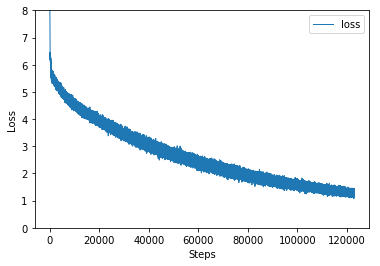

In [13]:
import matplotlib.pyplot as plt
def draw_loss(loss_history):
    
    plt.plot(loss_history,label="loss",linewidth=1)
    plt.legend(loc='best')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.ylim((0, int(max(loss_history))))
    plt.show()

    
draw_loss(l_h)

In [12]:
with open("./data/char2id_dict.pickle",'rb') as f:
    char2id_dict = pickle.load(f)


def generate(model, start_words, ix2char, char2ix, prefix_words=None):
    model.eval()
    
    results = list(start_words)
    start_word_len = len(start_words)

    input_ = torch.Tensor([char2ix['<start>']]).view(1, 1).long().to(device)
    
   
    
    hidden = model.init_hidden(input_.size(1)).to(device)
    

    if prefix_words:
        for word in prefix_words:
            output, hidden = model(input_, hidden)
#             input_ = input_.detach().new([char2ix[word]]).view(1, 1)

    for i in range(200):
        output, hidden = model(input_, hidden)
#         print(output.detach())
        if i < start_word_len:
            w = results[i]
            
            input_ = input_.data.new([char2ix[w]]).view(1, 1)
        else:
            
            top_index = output.data[0].topk(1)[1][0].item()
            w = ix2char[top_index]
            print(w)
            results.append(w)
            input_ = input_.detach().new([top_index]).view(1, 1)
        if w == '<EOS>':
            del results[-1]
            break
    return results

def gen_acrostic(model,start_words,ix2word,word2ix, prefix_words = None):
    model.eval()

    results = []
    start_word_len = len(start_words)
    input_ = torch.Tensor([word2ix['<start>']]).view(1,1).long().to(device)
    
    hidden = model.init_hidden(input_.size(1)).to(device)
    
    index=0 # 用来指示已经生成了多少句藏头诗
    # 上一个词
    pre_word='<start>'
 
    if prefix_words:
        for word in prefix_words:
            output,hidden = model(input_ ,hidden)
            input_  = torch.tensor(input_.detach().new([word2ix[word]])).view(1,1)
 
    for i in range(800):
        output,hidden = model(input_ ,hidden)
       
        top_index  = output.detach()[0].topk(1)[1][0].item()
        
        w = ix2word[top_index]
        print(w)
       
        if pre_word  in ('。','<start>') :
            # 如果遇到句号，藏头的词送进去生成
 
            if index==start_word_len:
                # 如果生成的诗歌已经包含全部藏头的词，则结束
                break
            else:  
                # 把藏头的词作为输入送入模型
                w = start_words[index]
                index+=1
                input_  = torch.tensor(input_.detach().new([word2ix[w]])).view(1,1)    
        else:
            # 否则的话，把上一次预测是词作为下一个词输入
            input_t = torch.tensor(input_.detach().new([word2ix[w]])).view(1,1)
        results.append(w)
        pre_word = w



start_word = '今朝'
prefix_word = None


result = generate(model,start_word,id2char_dict,char2id_dict,prefix_word)
# result = gen_acrostic(model,start_word,id2char_dict,char2id_dict,prefix_word)
print(''.join(result))

好
南
洛
，
相
將
禁
皎
十
。
雲
山
昨
夜
夜
，
還
去
始
潸
然
。
<EOS>
今朝好南洛，相將禁皎十。雲山昨夜夜，還去始潸然。


In [14]:
torch.save(model, 'poetry_model.pickle')

/home/sin/anaconda3/envs/pytorch_learn/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
